# **1 - Clustering: Balearic Grids**

##### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd
import rasterio as rio
import copy
import leiap_survey.utils as utils


from pathlib import Path
from sklearn.cluster import SpectralBiclustering
from tqdm.notebook import tnrange, tqdm

# Read data

##### Project main path

In [2]:
# Change path so that it points to  were data is located
pth = Path(r'../data')
pth 

WindowsPath('../data')

### Read Geographic information 

##### Read 80 x 80m Grid
This shapefile contains the survey area divided into 80 x80m

In [3]:
fn = pth / 'geography' / 'grid80.shp'
fn

WindowsPath('../data/geography/grid80.shp')

In [4]:
grid = gpd.read_file(fn, encoding= 'utf-8')
grid = grid.reset_index()
del grid['Id']
grid = grid.rename( columns = {'index': 'id'})

grid.head(2)

,id,geometry
0,0,"POLYGON ((531966.615 4385295.031, 531966.615 4..."
1,1,"POLYGON ((532046.615 4385295.031, 532046.615 4..."


### Read Balearic survey data by grid (80x80m)c
The following files contain the distribution of Balearic pottery found in each grid cell organized by original production and pottery type

In [5]:
# read types
fn = pth / 'artifacts' / 'by_grid'/ 'grid80_types.txt'
grid_types = pd.read_csv(fn)
grid_types.head(3)

,grid80,Amphora,Coarseware,Commonware,Fineware
0,2,1.0,1.0,0.0,0.0
1,11,1.0,0.0,0.0,0.0
2,13,1.0,0.0,0.0,0.0


In [6]:
# read productions
fn = pth / 'artifacts' / 'by_grid'/ 'grid80_productions.txt'
grid_prods = pd.read_csv(fn)
grid_prods.head(3)

,grid80,AtBlckGlz,Balearic,CamBlckGlzA,CamBlckGlzB,CmedPuAm,EbBlckGlz,EbPuAm,EbPuCom,GrItAm,IbAm,IbCom,ItAm,ItCom,MasAm,PuAm,PuCom,SoItVesCaAm
0,2,0.0,8.4,0.0,0.0,0.0,0.0,45.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11,0.0,0.0,0.0,0.0,0.0,0.0,6.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13,0.0,0.0,0.0,0.0,0.0,0.0,38.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Assemblage Clustering

There are several options to do clustering based on binary data (presence and absence), here we will be using Spectral Biclustering.

##### Which dataset?

In [7]:
data = grid_types

For this method we want to use our own dissimilarity coefficient. In order to do this, we shall first create a function that takes four parameters (a, b, c, d) and calculates the dissimilarity coefficient for two rows or grid cells. The parameters correspond to the following table,

|               |*Presence2*| *Absence2*|
|:-------------:|:---------:|:---------:|
|**_Presence1_**|     a     |     b     |
|**_Absence1_** |     c     |     d     |

Here *a* would correspond to the number of categories (= ceramic types) that are present in two rows or grid cells we are comparing, *b* would correspond to the number of types that are in row1 and not in row2 and so on. Once we have these counts we plug it in the following formula: 

$$ diss = \frac{b+c}{5a + b + c + \frac{d}{5}} $$

to calculate a dissimilarity coefficient between the two rows (grid cells)

#### Define *Assemblage* dissimilarity coefficient

The following function defines the dissimilarity used to determine how di/similiar two grid cell are from each other based on the presence/absence of pottery types recovered within each grid cell. 

In [8]:
# Dissimilarity metric
def mll(a,b,c,d, coefad=5, coefbc=1):
    return (coefbc*b + coefbc*c) / (coefad*a + coefbc*b + coefbc*c + d/coefad)

#### Create dissimilarity matrix

In [9]:
# generate dissimilarity matrix
from leiap_survey.cluster import create_binary_metric_matrix
D_mll = create_binary_metric_matrix(data.values, mll)

##### Silhouette Analysis
Before clustering grid cells we use silhouette plots and coefficients to help determine what number of clusters we want to group our grid cells into

For n_clusters = 2 The average silhouette_score is : 0.6862391451553093
For n_clusters = 3 The average silhouette_score is : 0.6773990110316647
For n_clusters = 4 The average silhouette_score is : 0.7299622198086693
For n_clusters = 5 The average silhouette_score is : 0.7942596783006292
For n_clusters = 6 The average silhouette_score is : 0.8806737575911472
For n_clusters = 7 The average silhouette_score is : 0.9189159195386286
For n_clusters = 8 The average silhouette_score is : 0.9409140596371584
For n_clusters = 9 The average silhouette_score is : 0.9851371951219511
For n_clusters = 10 The average silhouette_score is : 0.9939024390243902


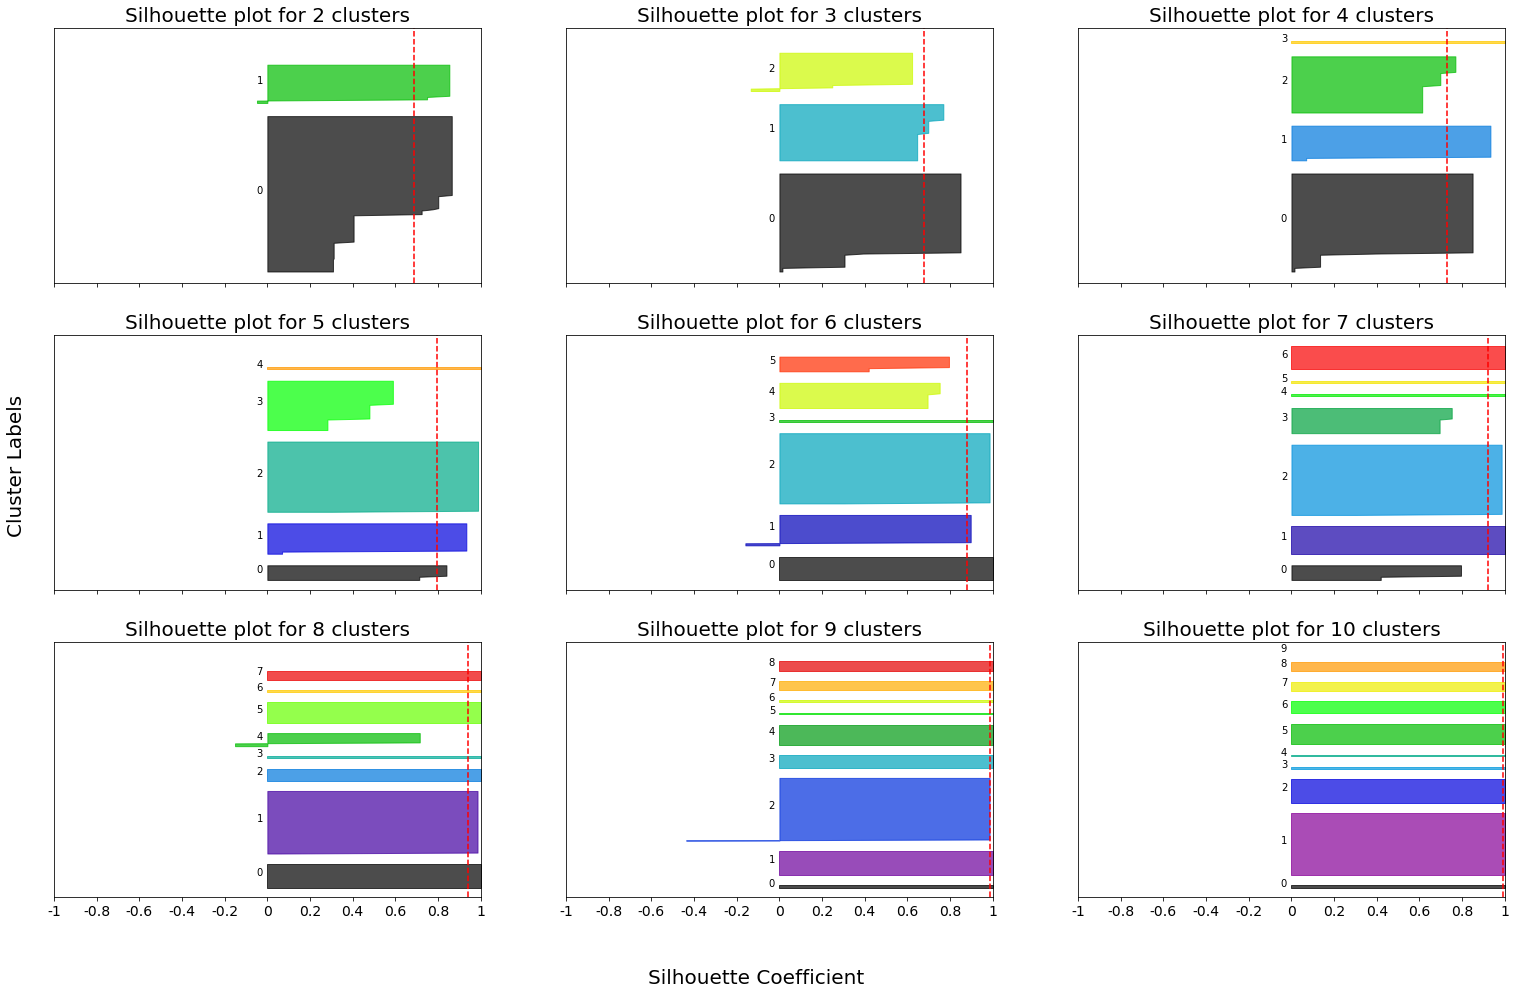

In [10]:
# Generate silhouette plots and coefficients for different number of groups
from leiap_survey.cluster import plot_silhouette

clst_kw = {'random_state': 13, 'n_init':100, 'svd_method':'arpack'}
plot_silhouette(D_mll, [2,3,4,5,6,7,8,9,10], SpectralBiclustering, clst_kw, func_lbl= lambda Clusterer: Clusterer.row_labels_,
                save='silhouette_spectral', size=(26,16), colrow=(3,3))

# Uncomment to save figure
#plt.savefig(pth /'output'/ 'reading_traces' /'figures'/ 'Silhouette Plots.png', dpi=300)

#### Run *Spectral biclustering* 

Spectral biclustering is used to cluster grid cells into seven categories using the dissimilarity matrix generated after applying the *new assemblage dissimilarity coefficient*.

In [11]:
# Run biclustering for 7 clusters
Biclst = SpectralBiclustering(n_clusters=7, random_state= 13, n_init=100, svd_method='arpack')
Biclst.fit(D_mll)

SpectralBiclustering(n_clusters=7, n_init=100, random_state=13,
                     svd_method='arpack')

In [12]:
# Generate a column for each grid cell with the label of the cluster it belongs to.
from leiap_survey.cluster import sort_cluster_labels

# sort cluster labels so that clusters with the largest number of elements have the smallest numerical label
data['Biclst'] = sort_cluster_labels(Biclst.row_labels_)

We merge our the results with the grid geopandas dataframe to identify each grid cell in this dataframe with its cluster label 

In [13]:
# merging the results of clustering with its spatial component
grid_out = grid.merge(data[['grid80', 'Biclst']], left_on='id', right_on='grid80', how= 'inner')

In [14]:
grid_out.head(4)

,id,geometry,grid80,Biclst
0,2,"POLYGON ((532126.615 4385295.031, 532126.615 4...",2,4
1,11,"POLYGON ((531806.615 4385535.031, 531806.615 4...",11,0
2,13,"POLYGON ((531966.615 4385535.031, 531966.615 4...",13,0
3,14,"POLYGON ((532046.615 4385535.031, 532046.615 4...",14,0


In [15]:
# save clustered grids

fn = pth / 'clustered' / 'assemblage' / 'grid' / 'cluster_grid80.shp'

# Uncomment and change path above to save grid geopandas
#grid_out.to_file(fn, index= False)